In [5]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import os
from scipy import misc
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pickle
import numpy as np

CIFAR10/CIFAR100地址：

http://www.cs.toronto.edu/~kriz/cifar.html

## 加载数据集

In [6]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

### 加载标签

In [7]:
meta=unpickle("./cifar-100-python/meta")

In [8]:
meta.keys()

dict_keys([b'fine_label_names', b'coarse_label_names'])

### 粗糙标签名

In [9]:
meta[b'coarse_label_names']

[b'aquatic_mammals',
 b'fish',
 b'flowers',
 b'food_containers',
 b'fruit_and_vegetables',
 b'household_electrical_devices',
 b'household_furniture',
 b'insects',
 b'large_carnivores',
 b'large_man-made_outdoor_things',
 b'large_natural_outdoor_scenes',
 b'large_omnivores_and_herbivores',
 b'medium_mammals',
 b'non-insect_invertebrates',
 b'people',
 b'reptiles',
 b'small_mammals',
 b'trees',
 b'vehicles_1',
 b'vehicles_2']

### 精细标签名共100个（100个分类）

In [10]:
len(meta[b'fine_label_names'])

100

### 粗糙标签共20个分类

In [11]:
len(meta[b'coarse_label_names'])

20

### 加载训练集

In [12]:
trainset=unpickle("./cifar-100-python/train")

In [53]:
trainset.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

In [54]:
trainset[b'data'].shape

(50000, 3072)

In [13]:
trainset_x=trainset[b'data']

In [14]:
n_trainset=len(trainset_x)
n_trainset

50000

In [15]:
n_class=len(meta[b'coarse_label_names'])
n_class

20

In [16]:
trainset_y=trainset[b'coarse_labels']

### 加载测试集

In [17]:
testset=unpickle("./cifar-100-python/test")

In [18]:
testset_x=testset[b'data']

In [19]:
testset_y=testset[b'coarse_labels']

### 将数据集图像数据转成RGB图像

In [21]:
trainset_x=trainset_x.reshape(-1,3,32,32)

In [22]:
trainset_x=np.rollaxis(trainset_x, 1, 4)

In [23]:
trainset_x.shape

(50000, 32, 32, 3)

In [24]:
testset_x=testset_x.reshape(-1,3,32,32)
testset_x=np.rollaxis(testset_x, 1, 4)
testset_x.shape

(10000, 32, 32, 3)

6
b'household_furniture'


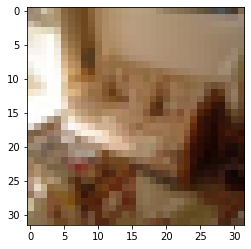

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
import random

index = random.randint(0, len(trainset_x))
plt.figure()
plt.imshow(trainset_x[index])
print(trainset_y[index])
print(meta[b'coarse_label_names'][trainset_y[index]])

## 数据增强处理函数

In [27]:
import os
import cv2
import numpy as np
import shutil
from PIL import Image
import sys

current_num = 0

def CLAHE(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(img)
    return cl1

def Histograms_Equalization(img):
    equ = cv2.equalizeHist(img)
    return equ

def make_one_hot(data, num):
    return (np.arange(num)==data[:,None]).astype(np.integer)

## 处理训练集

In [28]:
from sklearn.utils import shuffle

new_X_train = []
new_y_train = []
for index in range(len(trainset_x)):
    sys.stdout.write(" {} / {}\r".format(index, len(trainset_x)))

    img_gray = cv2.cvtColor(trainset_x[index], cv2.COLOR_RGB2GRAY)

    new_X_train.append(img_gray.astype('float32') / 255.0)
    new_y_train.append(trainset_y[index])
    
    he_image = Histograms_Equalization(img_gray)
    new_X_train.append(he_image.astype('float32') / 255.0)
    new_y_train.append(trainset_y[index])
    
    clahe_img = CLAHE(img_gray)
    new_X_train.append(clahe_img.astype('float32') / 255.0)
    new_y_train.append(trainset_y[index])
    
    
print("All done!")
all_xs = np.expand_dims(new_X_train, 3)
all_ys = make_one_hot(np.array(new_y_train), n_class)
train_xs, valid_xs, train_ys, valid_ys = train_test_split(
    all_xs, all_ys, test_size=0.2, random_state=0)
# all_xs, all_ys = shuffle(np.array(new_X_train), np.array(new_y_train), random_state=0)

pickle.dump(all_xs, open('all_xs.p', 'wb'))
pickle.dump(all_ys, open('all_ys.p', 'wb'))

All done!50000


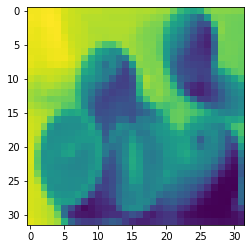

In [30]:
index = 17245 
img_gray = cv2.cvtColor(trainset_x[index], cv2.COLOR_RGB2GRAY)
plt.figure()
plt.imshow(img_gray)

17245


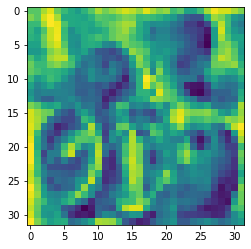

In [31]:
index = 17245 
print(index)
img_gray = cv2.cvtColor(trainset_x[index], cv2.COLOR_RGB2GRAY)
# img_gray = Histograms_Equalization(img_gray)
img_gray = CLAHE(img_gray)
plt.figure()
plt.imshow(img_gray)

## 处理测试集

In [32]:
from sklearn.utils import shuffle

test_set = []
for j in range(len(testset_x)):
    img_gray = cv2.cvtColor(testset_x[j], cv2.COLOR_RGB2GRAY)
#     img_gray = Histograms_Equalization(img_gray)
    img_gray = np.expand_dims(img_gray, 2)
    img_gray = img_gray / 255.0
    test_set.append(img_gray)

test_set = np.array(test_set)
y_test = make_one_hot(np.array(testset_y), n_class)

def get_batches(Xs, ys, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start + batch_size, len(Xs))
        yield Xs[start:end], ys[start:end]

## 构建网络模型

In [41]:
import tensorflow as tf
import datetime

class network(object):
    def __init__(self):

        self.graph = tf.Graph()
        with self.graph.as_default():
            self.x = tf.placeholder(tf.float32, shape=[None, 32, 32, 1], name='input_tensor')
            self.y = tf.placeholder(tf.float32, shape=[None, n_class], name='labels')
            
            conv1 = tf.layers.conv2d(self.x, filters=100, kernel_size=5, activation=tf.nn.relu)            
            print("conv1.shape = ", conv1.get_shape())  # (?, 28, 28, 100)    
            self.conv1 = tf.layers.max_pooling2d(conv1, pool_size=2, strides=2)

            conv2 = tf.layers.conv2d(self.conv1, filters=150, kernel_size=3, activation=tf.nn.relu)            
            print("conv2.shape = ", conv2.get_shape())  # (?, 12, 12, 150)     
            self.conv2 = tf.layers.max_pooling2d(conv2, pool_size=2, strides=2)
            print("max_pool conv2.shape = ", self.conv2.get_shape())  # (?, 6, 6, 150)  

            conv3 = tf.layers.conv2d(self.conv2, filters=250, kernel_size=3, padding='same', activation=tf.nn.relu)            
            print("conv3.shape = ", conv3.get_shape())  # (?, 6, 6, 250)  
            self.conv3 = tf.layers.max_pooling2d(conv3, pool_size=2, strides=2)
            print("max_pool conv3.shape = ", self.conv3.get_shape())  # (?, 3, 3, 250)  

            self.fc0   = tf.layers.flatten(self.conv3)
            print("fc0.shape = ", self.fc0.get_shape())  # (?, 2250)  

            self.fc1 = tf.layers.dense(self.fc0, units=512, activation=tf.nn.relu)

            self.fc2 = tf.layers.dense(self.fc1, units=300, activation=tf.nn.relu)
            
            self.logits = tf.layers.dense(self.fc2, units=n_class)

            with tf.name_scope('loss'):
                self.cross_entropy = tf.reduce_mean(
                    tf.losses.softmax_cross_entropy(self.y, logits=self.logits))

            with tf.name_scope('train_step'):
                self.train_step = tf.train.AdamOptimizer(1e-4).minimize(self.cross_entropy)

            with tf.name_scope('accuracy'):
                correct_prediction = tf.equal(tf.argmax(self.logits,1), tf.argmax(self.y,1))
                self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

            self.saver = tf.train.Saver()
            self.sess = tf.Session(graph=self.graph)
            self.sess.run(tf.global_variables_initializer())

            self.save_dir = './session'
            if not os.path.isdir(self.save_dir):
                os.mkdir(self.save_dir)
            self.ckpt = tf.train.get_checkpoint_state(self.save_dir)
            if self.ckpt and self.ckpt.model_checkpoint_path:
                self.saver.restore(self.sess, tf.train.latest_checkpoint(self.save_dir))
                print("Successfully loaded:", tf.train.latest_checkpoint(self.save_dir))
            else:
                print("Could not find old network weights")

    def training(self, xs, labels, ii, epoch_i, batch_i, batch_num):
        feed_dict = {
            self.x: xs,
            self.y: labels
        }

        _, accuracy, loss = self.sess.run([self.train_step, self.accuracy, self.cross_entropy], feed_dict=feed_dict)
        if (ii % 20 == 0):
            time_str = datetime.datetime.now().isoformat()
            print('Training {}: Epoch {:>3} Batch {:>4}/{}   train_loss = {:.5f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    batch_num,
                    loss))

        return accuracy, loss
    
    def testing(self, xs, labels, ii, epoch_i, batch_i, batch_num):
        feed_dict = {
            self.x: xs,
            self.y: labels
        }

        accuracy, loss = self.sess.run([self.accuracy, self.cross_entropy], feed_dict=feed_dict)
        if (ii % 20 == 0):
            time_str = datetime.datetime.now().isoformat()
            print('#Testing# {}: Epoch {:>3} Batch {:>4}/{} accuracy = {:.3f}  test_loss = {:.5f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    batch_num,
                    accuracy,
                    loss))

        return accuracy, loss
            
    def save(self):
        save_path = self.saver.save(self.sess, os.path.join(self.save_dir, 'best_model.ckpt'))    
        print("Model saved in file: {}".format(save_path))
        
    def forward(self, xs):  
        feed_dict = {
            self.x: xs
        }
        logits = self.sess.run([tf.nn.softmax(self.logits)], feed_dict=feed_dict)
        logits = np.reshape(np.array(logits), (n_classes))

        return logits
    

## 开始训练

In [49]:
epochs = 5
net = network()
total_batch_size = 64

best_loss = 9999

for ii in range(epochs):
    train_batches = get_batches(train_xs, train_ys, total_batch_size)
    test_batches = get_batches(valid_xs, valid_ys, total_batch_size)
    batch_num = (len(train_xs) // total_batch_size)
    for batch_i in range(batch_num):
        x, y = next(train_batches)
        net.training(x, y, ii * (batch_num) + batch_i, ii, batch_i, batch_num)
        
    batch_num = (len(valid_xs) // total_batch_size)
    test_loss = 0.0
    test_acc = 0.0
    for batch_i  in range(batch_num):
        x, y = next(test_batches)
        acc, loss = net.testing(x, y, ii * (batch_num) + batch_i, ii, batch_i, batch_num)
        test_loss = test_loss + loss
        test_acc = test_acc + acc
        
    test_acc = test_acc / batch_num
    test_loss = test_loss / batch_num
    if test_loss < best_loss:
        best_loss = test_loss
        print("best loss = {}  acc = {}".format(best_loss, test_acc))
        net.save()
    else:
        print("test loss = {}  acc = {}".format(test_loss, test_acc))



conv1.shape =  (?, 28, 28, 100)
conv2.shape =  (?, 12, 12, 150)
max_pool conv2.shape =  (?, 6, 6, 150)
conv3.shape =  (?, 6, 6, 250)
max_pool conv3.shape =  (?, 3, 3, 250)
fc0.shape =  (?, 2250)
Could not find old network weights
Training 2019-06-09T20:19:41.341654: Epoch   0 Batch    0/1875   train_loss = 2.99788
Training 2019-06-09T20:20:00.219567: Epoch   0 Batch   20/1875   train_loss = 2.99611
Training 2019-06-09T20:20:18.964997: Epoch   0 Batch   40/1875   train_loss = 2.99396
Training 2019-06-09T20:20:38.782334: Epoch   0 Batch   60/1875   train_loss = 2.99717
Training 2019-06-09T20:20:57.592695: Epoch   0 Batch   80/1875   train_loss = 2.98443
Training 2019-06-09T20:21:16.464490: Epoch   0 Batch  100/1875   train_loss = 2.98561
Training 2019-06-09T20:21:35.238281: Epoch   0 Batch  120/1875   train_loss = 2.97820
Training 2019-06-09T20:21:54.033590: Epoch   0 Batch  140/1875   train_loss = 2.95885
Training 2019-06-09T20:22:12.814279: Epoch   0 Batch  160/1875   train_loss = 2.89

Training 2019-06-09T20:49:44.470360: Epoch   0 Batch 1860/1875   train_loss = 2.48097
#Testing# 2019-06-09T20:49:58.315169: Epoch   0 Batch    0/468 accuracy = 0.344  test_loss = 2.25901
#Testing# 2019-06-09T20:50:04.986812: Epoch   0 Batch   20/468 accuracy = 0.234  test_loss = 2.36429
#Testing# 2019-06-09T20:50:11.666846: Epoch   0 Batch   40/468 accuracy = 0.219  test_loss = 2.50277
#Testing# 2019-06-09T20:50:18.375389: Epoch   0 Batch   60/468 accuracy = 0.203  test_loss = 2.49642
#Testing# 2019-06-09T20:50:25.058985: Epoch   0 Batch   80/468 accuracy = 0.203  test_loss = 2.36249
#Testing# 2019-06-09T20:50:31.740721: Epoch   0 Batch  100/468 accuracy = 0.281  test_loss = 2.38989
#Testing# 2019-06-09T20:50:38.426410: Epoch   0 Batch  120/468 accuracy = 0.234  test_loss = 2.48016
#Testing# 2019-06-09T20:50:45.103645: Epoch   0 Batch  140/468 accuracy = 0.281  test_loss = 2.36974
#Testing# 2019-06-09T20:50:52.333436: Epoch   0 Batch  160/468 accuracy = 0.219  test_loss = 2.48809
#Test

Training 2019-06-09T21:14:37.722854: Epoch   1 Batch 1305/1875   train_loss = 2.12835
Training 2019-06-09T21:14:56.820860: Epoch   1 Batch 1325/1875   train_loss = 2.18542
Training 2019-06-09T21:15:15.841435: Epoch   1 Batch 1345/1875   train_loss = 2.20790
Training 2019-06-09T21:15:34.893095: Epoch   1 Batch 1365/1875   train_loss = 2.45721
Training 2019-06-09T21:15:53.966006: Epoch   1 Batch 1385/1875   train_loss = 1.97172
Training 2019-06-09T21:16:13.005496: Epoch   1 Batch 1405/1875   train_loss = 2.44807
Training 2019-06-09T21:16:33.528596: Epoch   1 Batch 1425/1875   train_loss = 2.17413
Training 2019-06-09T21:16:52.615904: Epoch   1 Batch 1445/1875   train_loss = 2.35742
Training 2019-06-09T21:17:11.795621: Epoch   1 Batch 1465/1875   train_loss = 2.23739
Training 2019-06-09T21:17:30.932954: Epoch   1 Batch 1485/1875   train_loss = 2.07905
Training 2019-06-09T21:17:49.965148: Epoch   1 Batch 1505/1875   train_loss = 2.48690
Training 2019-06-09T21:18:09.023241: Epoch   1 Batch 1

Training 2019-06-09T21:38:59.603547: Epoch   2 Batch  790/1875   train_loss = 2.20324
Training 2019-06-09T21:39:18.486534: Epoch   2 Batch  810/1875   train_loss = 1.94314
Training 2019-06-09T21:39:37.400845: Epoch   2 Batch  830/1875   train_loss = 2.48222
Training 2019-06-09T21:39:56.329811: Epoch   2 Batch  850/1875   train_loss = 2.13817
Training 2019-06-09T21:40:15.276380: Epoch   2 Batch  870/1875   train_loss = 2.09990
Training 2019-06-09T21:40:34.157197: Epoch   2 Batch  890/1875   train_loss = 2.02358
Training 2019-06-09T21:40:53.032413: Epoch   2 Batch  910/1875   train_loss = 1.96964
Training 2019-06-09T21:41:11.981852: Epoch   2 Batch  930/1875   train_loss = 2.13029
Training 2019-06-09T21:41:30.906653: Epoch   2 Batch  950/1875   train_loss = 2.18091
Training 2019-06-09T21:41:49.760378: Epoch   2 Batch  970/1875   train_loss = 2.04798
Training 2019-06-09T21:42:08.616007: Epoch   2 Batch  990/1875   train_loss = 2.00484
Training 2019-06-09T21:42:27.508620: Epoch   2 Batch 1

Training 2019-06-09T22:02:24.197711: Epoch   3 Batch  235/1875   train_loss = 2.25501
Training 2019-06-09T22:02:43.019628: Epoch   3 Batch  255/1875   train_loss = 2.01086
Training 2019-06-09T22:03:02.628389: Epoch   3 Batch  275/1875   train_loss = 2.19400
Training 2019-06-09T22:03:22.102097: Epoch   3 Batch  295/1875   train_loss = 2.02915
Training 2019-06-09T22:03:41.072676: Epoch   3 Batch  315/1875   train_loss = 2.30974
Training 2019-06-09T22:03:59.933680: Epoch   3 Batch  335/1875   train_loss = 1.80954
Training 2019-06-09T22:04:18.837440: Epoch   3 Batch  355/1875   train_loss = 1.80072
Training 2019-06-09T22:04:37.707231: Epoch   3 Batch  375/1875   train_loss = 1.89397
Training 2019-06-09T22:04:56.598497: Epoch   3 Batch  395/1875   train_loss = 2.12179
Training 2019-06-09T22:05:15.539937: Epoch   3 Batch  415/1875   train_loss = 2.24740
Training 2019-06-09T22:05:34.382515: Epoch   3 Batch  435/1875   train_loss = 1.94045
Training 2019-06-09T22:05:53.174022: Epoch   3 Batch  

#Testing# 2019-06-09T22:29:41.287901: Epoch   3 Batch  256/468 accuracy = 0.438  test_loss = 1.82348
#Testing# 2019-06-09T22:29:47.938062: Epoch   3 Batch  276/468 accuracy = 0.406  test_loss = 2.05334
#Testing# 2019-06-09T22:29:54.589912: Epoch   3 Batch  296/468 accuracy = 0.391  test_loss = 1.93162
#Testing# 2019-06-09T22:30:01.237163: Epoch   3 Batch  316/468 accuracy = 0.406  test_loss = 1.83407
#Testing# 2019-06-09T22:30:07.884956: Epoch   3 Batch  336/468 accuracy = 0.359  test_loss = 2.03912
#Testing# 2019-06-09T22:30:14.540767: Epoch   3 Batch  356/468 accuracy = 0.531  test_loss = 1.77512
#Testing# 2019-06-09T22:30:21.185006: Epoch   3 Batch  376/468 accuracy = 0.391  test_loss = 1.92428
#Testing# 2019-06-09T22:30:27.847815: Epoch   3 Batch  396/468 accuracy = 0.375  test_loss = 1.93500
#Testing# 2019-06-09T22:30:34.501514: Epoch   3 Batch  416/468 accuracy = 0.281  test_loss = 2.16452
#Testing# 2019-06-09T22:30:41.142953: Epoch   3 Batch  436/468 accuracy = 0.438  test_loss 

Training 2019-06-09T22:57:10.999107: Epoch   4 Batch 1640/1875   train_loss = 1.45643
Training 2019-06-09T22:57:30.154800: Epoch   4 Batch 1660/1875   train_loss = 1.55792
Training 2019-06-09T22:57:49.240498: Epoch   4 Batch 1680/1875   train_loss = 1.86889
Training 2019-06-09T22:58:08.341170: Epoch   4 Batch 1700/1875   train_loss = 1.63730
Training 2019-06-09T22:58:27.396891: Epoch   4 Batch 1720/1875   train_loss = 1.78511
Training 2019-06-09T22:58:46.478558: Epoch   4 Batch 1740/1875   train_loss = 1.58699
Training 2019-06-09T22:59:06.888858: Epoch   4 Batch 1760/1875   train_loss = 1.76029
Training 2019-06-09T22:59:26.232135: Epoch   4 Batch 1780/1875   train_loss = 2.02823
Training 2019-06-09T22:59:45.274038: Epoch   4 Batch 1800/1875   train_loss = 1.87375
Training 2019-06-09T23:00:04.345088: Epoch   4 Batch 1820/1875   train_loss = 1.62470
Training 2019-06-09T23:00:23.435480: Epoch   4 Batch 1840/1875   train_loss = 1.69743
Training 2019-06-09T23:00:42.487954: Epoch   4 Batch 1

In [50]:
net = network()

test_batches = get_batches(test_set, y_test, total_batch_size)
batch_num = (len(test_set) // total_batch_size)
test_loss = 0.0
test_acc = 0.0
for batch_i  in range(batch_num):
    x, y = next(test_batches)
    acc, loss = net.testing(x, y, 0 * (batch_num) + batch_i, 0, batch_i, batch_num)
    test_loss = test_loss + loss
    test_acc = test_acc + acc
        
test_acc = test_acc / batch_num
test_loss = test_loss / batch_num
print("test loss = {}  acc = {}".format(test_loss, test_acc))

conv1.shape =  (?, 28, 28, 100)
conv2.shape =  (?, 12, 12, 150)
max_pool conv2.shape =  (?, 6, 6, 150)
conv3.shape =  (?, 6, 6, 250)
max_pool conv3.shape =  (?, 3, 3, 250)
fc0.shape =  (?, 2250)
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./session/best_model.ckpt
Successfully loaded: ./session/best_model.ckpt
#Testing# 2019-06-10T09:10:19.299590: Epoch   0 Batch    0/156 accuracy = 0.500  test_loss = 1.93074
#Testing# 2019-06-10T09:10:26.021611: Epoch   0 Batch   20/156 accuracy = 0.344  test_loss = 1.95703
#Testing# 2019-06-10T09:10:32.692765: Epoch   0 Batch   40/156 accuracy = 0.344  test_loss = 2.03040
#Testing# 2019-06-10T09:10:39.882692: Epoch   0 Batch   60/156 accuracy = 0.344  test_loss = 2.07493
#Testing# 2019-06-10T09:10:47.132907: Epoch   0 Batch   80/156 accuracy = 0.438  test_loss = 1.96972
#Testing# 2019-06-10T09:10:53.803962: Epoch   0 Batch  100/156 accuracy = 0.375  test_loss = 2.024